# Темы:

1. Логистическая регрессия для бинарной классификации
2. Деревья решений (классификация)
3. K ближайших соседей

# Важно!
Классификация и кластеризация не тождественны:

* классификация - мы заранее знаем, какие классы в наших данных есть, и пытаемся новые объекты рассортировать по этим классам

* кластеризация - мы пытаемся найти новые классы объектов, заранее не знаем, какие и сколько их (про кластеризацию в следующий раз)

## Логистическая регрессия

В отличие от линейной, помогает нам предсказать категориальную переменную (как правило, бинарную)

Считается простым алгоритмом, но точность относительно невысокая

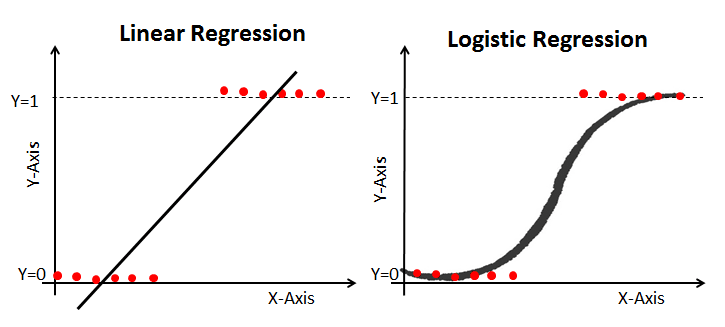

In [ ]:
# все импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import load_dataset
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

# деревья решений
from sklearn.datasets import load_iris # датасет от sklearn
from sklearn import tree
import graphviz

In [ ]:
# Давайте возьмем один из самый известных датасетов - пассажиры Титаника
df = load_dataset("titanic")
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
df['sex_coded'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)

### Документация

Все очень похоже на линейную регрессию: [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

+ Метрики: [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)

In [ ]:
x = df[['pclass', 'sex_coded']] # будем смотреть, как класс пассажира влияет на исход катастрофы
y = df["survived"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [ ]:
log_reg = LogisticRegression() # позже допишем сюда class_weight="balanced"
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

In [ ]:
df_logreg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_logreg

,Actual,Predicted
495,0,0
648,0,0
278,0,0
31,1,1
255,1,1
...,...,...
263,0,0
718,0,0
620,0,0
786,1,1


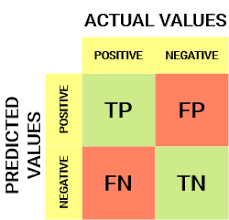

In [ ]:
confusion_matrix(y_pred, y_test)

array([[140,  29],
       [ 28,  71]])

In [ ]:
df['survived'].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [ ]:
print(classification_report(y_test, y_pred)) # несбалансированные классы
# можно добавить class_weight="balanced" в модель логистической регресии

# precision (точность) и recall (полнота)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       168
           1       0.72      0.71      0.71       100

    accuracy                           0.79       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм (аналогично для отрицательного).

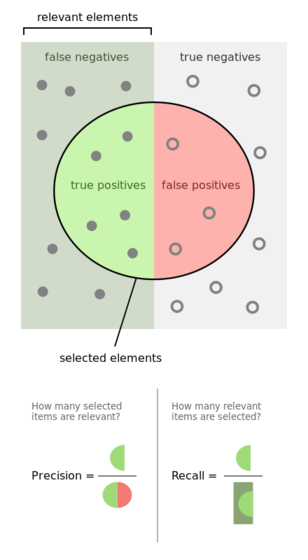

In [ ]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       168
           1       0.63      0.84      0.72       100

    accuracy                           0.76       268
   macro avg       0.76      0.77      0.75       268
weighted avg       0.79      0.76      0.76       268



In [ ]:
accuracy_score(y_pred, y_test) # точность модели
# приятная метрика: процент правильно предсказанных значений

0.7574626865671642

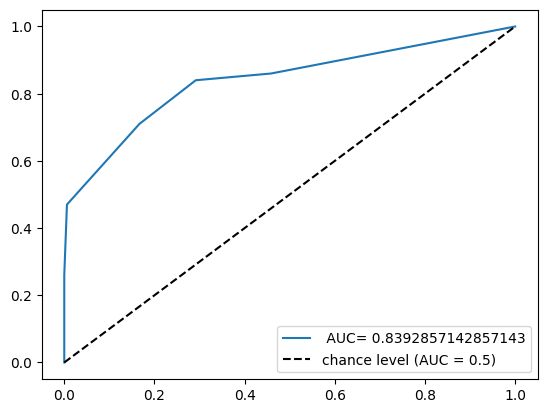

In [ ]:
y_pred_proba = log_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label=" AUC= "+str(auc))
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend(loc=4);

In [ ]:
print('coefficient:', log_reg.coef_)
print('intercept:', log_reg.intercept_) # для уравнения
print('r2 value:', log_reg.score(x, y))

coefficient: [[-0.84165472 -2.43986688]]
intercept: [3.38993858]
r2 value: 0.7508417508417509


In [ ]:
# перекодируйте пол и добавьте в модель
# будем смотреть, как класс и пол пассажира влияет на исход катастрофы

### Кросс-валидация

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values
# все возможные метрики
sklearn.metrics.get_scorer_names()

In [ ]:
scoring = {
           'roc_auc' : 'roc_auc',
           'accuracy' : 'accuracy',
           'precision' : 'precision',
           'recall' : 'recall'
           }
# выбираем те метрики, которые нам нужны, причем мы можем дать им свои обозначения

In [ ]:
scores = cross_validate(log_reg,
                        x_train,
                        y_train,
                        scoring=scoring,
                        cv=5,
                        return_estimator=True,
                        return_train_score=True)

scores

{'fit_time': array([0.01359749, 0.00452852, 0.00459218, 0.0044744 , 0.00445485]),
 'score_time': array([0.00831175, 0.00718784, 0.00746012, 0.00715995, 0.0071485 ]),
 'estimator': [LogisticRegression(class_weight='balanced'),
  LogisticRegression(class_weight='balanced'),
  LogisticRegression(class_weight='balanced'),
  LogisticRegression(class_weight='balanced'),
  LogisticRegression(class_weight='balanced')],
 'test_roc_auc': array([0.80639098, 0.84076262, 0.78152056, 0.85594846, 0.87349232]),
 'train_roc_auc': array([0.8357428 , 0.82807271, 0.84296154, 0.82440426, 0.8203059 ]),
 'test_accuracy': array([0.688     , 0.736     , 0.712     , 0.7983871 , 0.80645161]),
 'train_accuracy': array([0.76305221, 0.75100402, 0.75702811, 0.73547094, 0.73346693]),
 'test_precision': array([0.57575758, 0.625     , 0.60714286, 0.69491525, 0.70689655]),
 'train_precision': array([0.65822785, 0.64435146, 0.64777328, 0.62704918, 0.6244898 ]),
 'test_recall': array([0.7755102 , 0.81632653, 0.70833333, 0

In [ ]:
scores_df = pd.DataFrame.from_dict(scores)
scores_df

,fit_time,score_time,estimator,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.013597,0.008312,LogisticRegression(class_weight='balanced'),0.806391,0.835743,0.688000,0.763052,0.575758,0.658228,0.775510,0.808290
1,0.004529,0.007188,LogisticRegression(class_weight='balanced'),0.840763,0.828073,0.736000,0.751004,0.625000,0.644351,0.816327,0.797927
2,0.004592,0.007460,LogisticRegression(class_weight='balanced'),0.781521,0.842962,0.712000,0.757028,0.607143,0.647773,0.708333,0.824742
3,0.004474,0.007160,LogisticRegression(class_weight='balanced'),0.855948,0.824404,0.798387,0.735471,0.694915,0.627049,0.854167,0.788660
4,0.004455,0.007149,LogisticRegression(class_weight='balanced'),0.873492,0.820306,0.806452,0.733467,0.706897,0.624490,0.854167,0.788660


Чтобы вытащить одну из пяти моделей, нужно обратиться к ней по индексу:

In [ ]:
y_pred_cv_4 = scores['estimator'][4].predict(x_test)

Теперь мы можем или пользоваться лучшим эстиматором или обучиться снова на всех данных (вернуться к подходу 1).

### Еще примеры:
* [Спам-письма](https://github.com/svetlana21/Spam-classifier)
* [Мошенничество](https://vc.ru/u/1389654-machine-learning/651087-poshagovoe-rukovodstvo-po-obnaruzheniyu-moshennichestva-s-ispolzovaniem-logisticheskoy-regressii-python-kompleksnyy-podhod?__cf_chl_tk=7oOPtgov4EKf4x4jPZF9q_Zs63JVd4ywkbxs9kCRruA-1683867846-0-gaNycGzNDOU)
* [Кредиты в банке](https://medium.com/nuances-of-programming/%D0%BF%D0%BE%D1%88%D0%B0%D0%B3%D0%BE%D0%B2%D0%BE%D0%B5-%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8-%D0%B2-python-a7c650ae77c2)

## Другой популярный способ классификации - деревья решений

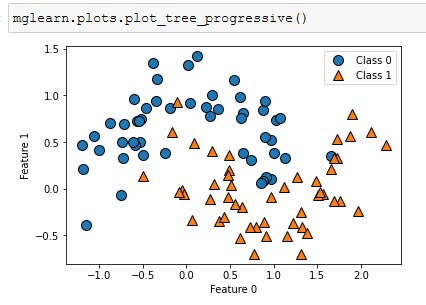

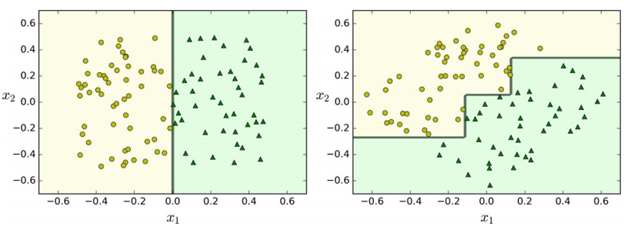

Это широко используемый алгоритм для классификации (что интересно, для регрессии его тоже используют - особенно случайный лес!)

[Документация](https://scikit-learn.ru/1-10-decision-trees/)

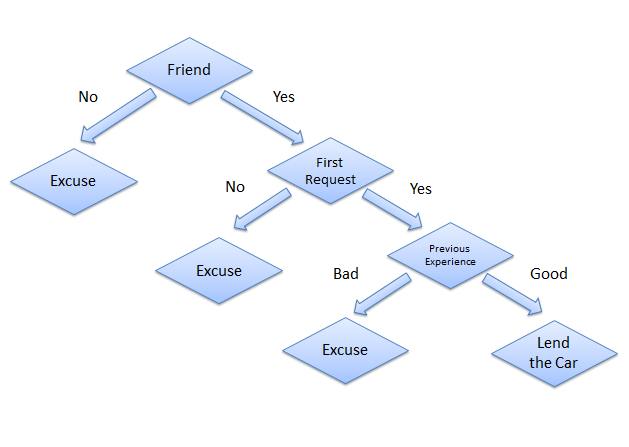

In [ ]:
iris = load_iris() # возьмем датасет с несколькими классами
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [ ]:
# там у нас векторы np
# но можно из него и обычный датафрейм собрать

df = pd.DataFrame(iris.data,columns=iris.feature_names)
df['target'] = iris.target

def f(n):
  if n == 0:
    return 'setosa'
  elif n == 1:
    return 'versicolor'
  else:
    return 'virginica'

df['target_text'] = df['target'].apply(f)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_text
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [ ]:
x = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df['target']
clf = tree.DecisionTreeClassifier(
                               # максимальная глубина дерева
                               max_depth=5,
                               # минимальное число элементов в узле для разбиения (может быть долей)
                               min_samples_split=5,
                               # минимальное число элементов в листе (может быть долей)
                               min_samples_leaf=5)
                               # минимальное значение дельты impurity (примеси)
                               # min_impurity_decrease=0
clf = clf.fit(x, y)

In [ ]:
class_names=iris.target_names
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

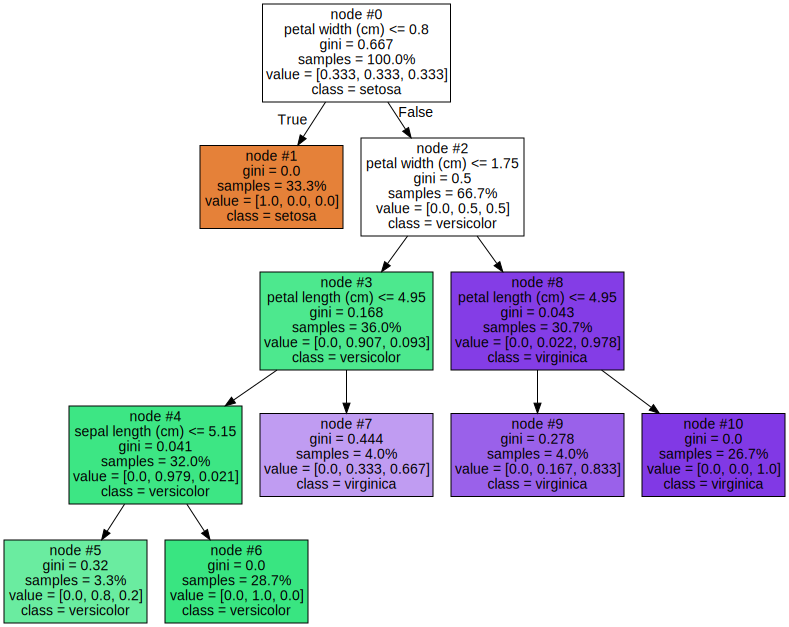

In [ ]:
dot_data = tree.export_graphviz(clf, out_file = None,
                      # задать названия столбцов
                      feature_names = df.columns[:4],
                      # названия классов - если они у нас есть, если нет, ставим None
                      class_names = ['setosa', 'versicolor', 'virginica'],
                      # показывать названия полей у численных значений внутри узла
                      label='all',
                      # раскрашивать узлы в цвет преобладающего класса
                      filled=True,
                      # показывать примеси - зашумленность, загрязненность
                      impurity=True,
                      # показывать номера узлов
                      node_ids=True,
                      # Показывать доли каждого класса в узлах (а не количество)
                      proportion=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# вклад, значимость каждого показателя
pd.DataFrame({'feature': df.columns[:4],
              'importance': clf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
3,petal width (cm),0.945812
2,petal length (cm),0.050378
0,sepal length (cm),0.003809
1,sepal width (cm),0.000000


### Проверим, насколько точна наша классификация

In [ ]:
x = df[df.columns[:4]]
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)
# stratify - способ поддерживать баланс классов в обучающей и тестовой выборке

# обучаем модель на тренировочных данных
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

In [ ]:
confusion_matrix(y_pred, y_test)

array([[15,  0,  0],
       [ 0, 15,  0],
       [ 0,  0, 15]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



### Снова кросс-валидация

In [ ]:
scores = cross_validate(clf,
                        x_train,
                        y_train,
                        scoring='accuracy',
                        cv=5,
                        return_estimator=True,
                        return_train_score=True)

scores

{'fit_time': array([0.00498104, 0.00211143, 0.00199699, 0.00198817, 0.00205445]),
 'score_time': array([0.00193858, 0.00159693, 0.00154424, 0.00160003, 0.00153494]),
 'estimator': [DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5),
  DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5),
  DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5),
  DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5),
  DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5)],
 'test_score': array([0.9047619 , 0.95238095, 0.9047619 , 0.9047619 , 1.        ]),
 'train_score': array([0.96428571, 0.95238095, 0.95238095, 0.97619048, 0.95238095])}

In [ ]:
scores_df = pd.DataFrame.from_dict(scores)
scores_df

,fit_time,score_time,estimator,test_score,train_score
0,0.004981,0.001939,"DecisionTreeClassifier(max_depth=5, min_sample...",0.904762,0.964286
1,0.002111,0.001597,"DecisionTreeClassifier(max_depth=5, min_sample...",0.952381,0.952381
2,0.001997,0.001544,"DecisionTreeClassifier(max_depth=5, min_sample...",0.904762,0.952381
3,0.001988,0.001600,"DecisionTreeClassifier(max_depth=5, min_sample...",0.904762,0.976190
4,0.002054,0.001535,"DecisionTreeClassifier(max_depth=5, min_sample...",1.000000,0.952381


### Можно также подбирать гиперпараметры:

In [ ]:
parameters = {'max_depth':range(2,20), 'criterion' : ['entropy', 'gini']}
grid = GridSearchCV(tree.DecisionTreeClassifier(), parameters)
grid.fit(x, y)
tree_model = grid.best_estimator_
print(grid.best_score_, grid.best_params_)

### KNN - k ближайших соседей

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [ ]:
x = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3) # пока оставляем параметры, скопированные из интернетика

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
y_pred

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# подберем гиперпараметры
parameters = {'n_neighbors':range(2,20), 'weights' : ['uniform', 'distance']}
grid = GridSearchCV(KNeighborsClassifier(), parameters)
grid.fit(x, y)
tree_model = grid.best_estimator_
print(grid.best_score_, grid.best_params_)